In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import math
import copy
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus']=False
# 폰트 설정
mpl.rc('font', family='Malgun Gothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

In [257]:
rental_data=pd.read_csv('C:/Users/user/Desktop/서울시청/데이터/독립변수/최종독립변수.csv',encoding='cp949')

## 전체 모델 변수 선정

## VIF 계산

In [259]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
dfX=rental_data.drop(['count','대여소번호'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12.306428,subway
1,5.983782,park
2,2.644331,상업지역
3,7.238008,weighted_LEN_mean
4,22.807591,mean_width
5,4.404129,주거
6,15.425864,school
7,10.776936,sports
8,55.197642,adult
9,47.204830,study


## 단계별 선택법

In [260]:
import statsmodels.api as sm
## 전진 단계별 선택법
variables = rental_data.columns[1:-2].tolist() ## 설명 변수 리스트
 
y = rental_data['count'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = rental_data[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = rental_data[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(rental_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [263]:
selected_variables

['weighted_LEN_mean',
 'bike',
 'game',
 'adult',
 'culture',
 'park',
 'bus_all',
 '상업지역',
 '공시지가',
 '지상층수',
 'sub_all',
 '주거',
 '용적율',
 'bus_dis']

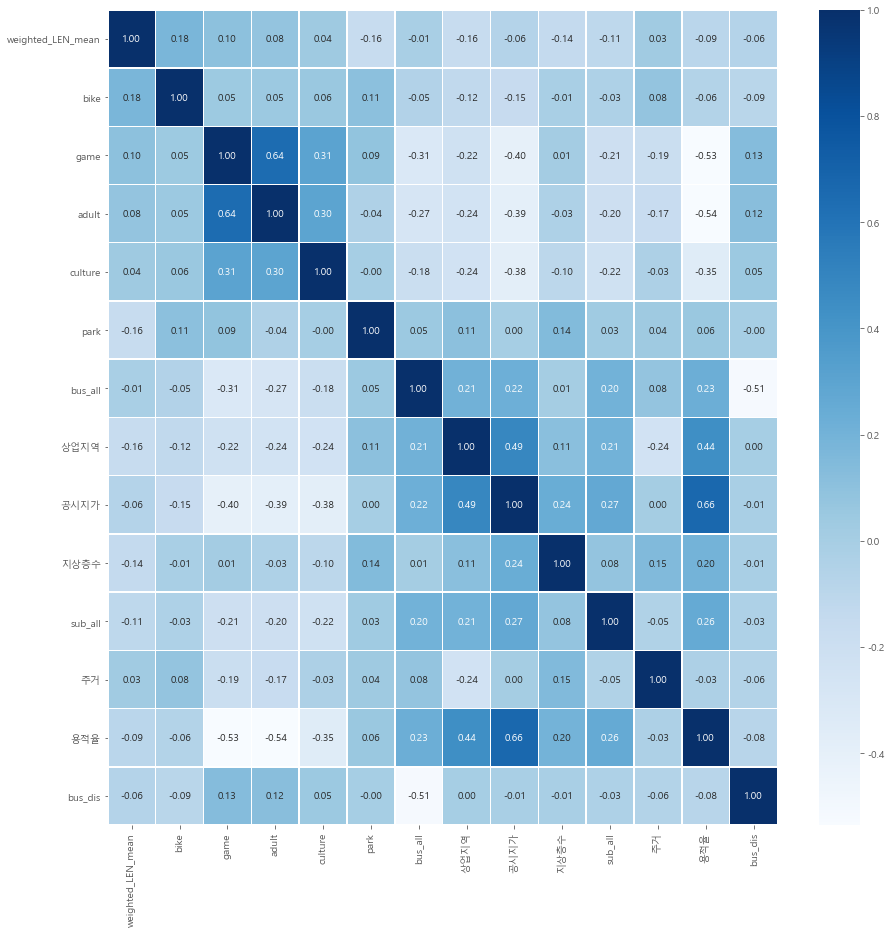

In [264]:
plt.figure(figsize=(15,15))
sns.heatmap(data = rental_data[['weighted_LEN_mean','bike','game','adult','culture','park','bus_all','상업지역','공시지가','지상층수','sub_all',
 '주거','용적율','bus_dis']].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

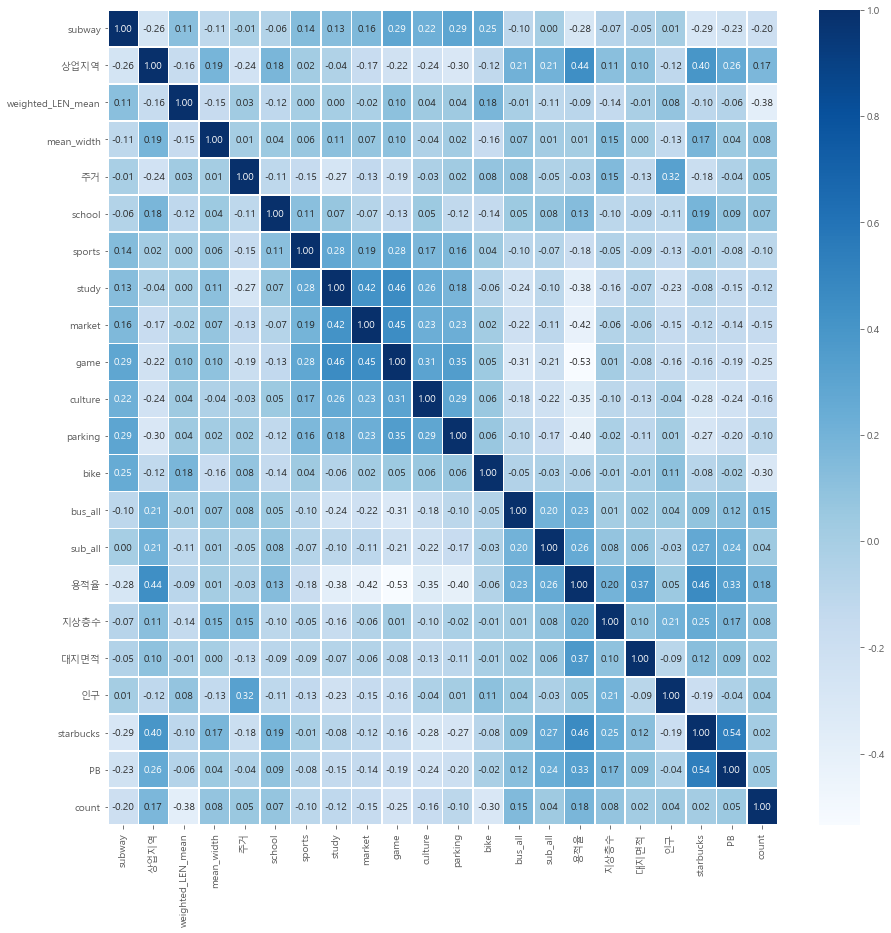

In [265]:
plt.figure(figsize=(15,15))
sns.heatmap(data = rental_data[[ 'subway',  '상업지역', 'weighted_LEN_mean', 'mean_width',
       '주거', 'school', 'sports', 'study', 'market', 'game', 
       'culture',  'parking', 'bike','bus_all', 'sub_all',
         '용적율', '지상층수', '대지면적', '인구','starbucks','PB','count']].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

## 변수 선택
* 지하철 출구
* 상업지역
* 도로폭
* 경사도
* 주거지역
* 학교
* 스포츠센터
* 학업
* 마켓
* 게임
* 문화시설
* 주차장
* 자전거 편의시설
* 버스 승하차
* 지하철 승하차
* 용적율
* 지상층수
* 대지면적
* 거주 인구
* 프렌차이즈